## 0. Set up the environment

In [237]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [238]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep  3 13:02:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    34W / 250W |   2873MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [239]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [240]:
import os
import numpy as np
import os
import sys
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import math
import random
import statistics as stats
import scipy
import sklearn
from scipy.io import loadmat
from scipy import signal
from progressbar import ProgressBar
from scipy.signal import butter, lfilter, filtfilt

In [241]:
import tensorflow as tf
from tensorflow import keras

from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, BatchNormalization, concatenate
from keras.models import Model, load_model
from keras import callbacks
from keras_preprocessing.sequence import pad_sequences

import keras.backend as K
K.set_image_data_format('channels_last')

In [242]:
SEED = 4224
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [243]:
# Utility functions
def empty_list(n, fill_default = 0):
    ll = [fill_default] * n
    return ll

## 1. Load data

In [ ]:
# Unzip the file containing training data
!unzip "/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/training_set.zip"

In [245]:
input_directory = '/content/training_set'

In [ ]:
# N.B. Sort the file names in alphanumerical order to have perfect 
# correspomdence btw signals, rpeak pos and labels
filenames = []
for f in os.listdir(input_directory):
  filenames.append(f)

filenames = sorted(filenames)

In [ ]:
# Create an array containing the IDs of the subjects 
# n.b. This might be useful when ECG signal will be split into single heartbeats
subjects = []
for f in filenames:
  if "ann" not in f.lower() and "rpk" not in f.lower():
    subjects.append(f[0:4])

num_subjects = len(subjects)
print(subjects)

In [248]:
print('Loading data...')

# N.B. We have 3 different types of files:
# - ECG data
# - Annotations of R-peaks ('ann')
# - R-peaks positions ('rpk')
# We want to load these files in 3 different data structures (list of objects)
recordings = []
rpeaks = []
labels = []
# N.B. One object for each subject

# Scan through all the data in the input directory. Depending on the name of the 
# file choose the right list to store the data in the 3 data structures
for f in filenames:
  # Get the path for the current file
  g = os.path.join(input_directory, f)
  if 'ann' in f.lower() and os.path.isfile(g):
    label = loadmat(g)
    label = np.asarray(label['labels'])
    labels.append(label)
  elif 'rpk' in f.lower() and os.path.isfile(g):
    rpeak = loadmat(g)
    rpeak = np.asarray(rpeak['rpeaks'])
    rpeaks.append(rpeak)
  else:
    record = loadmat(g)
    record = np.asarray(record['ecg'])
    recordings.append(record)

num_records = len(recordings)


Loading data...


In [ ]:
# Create a mask containing the sampling frequencies
# n.b. each ECG signal is measured over a time of 1800s
freqs = []
for rec in recordings:
  freqs.append(int(len(rec)/1800)) 

# Associate frequncies to subjects
subj_freqs = dict(zip(subjects, freqs))
print(subj_freqs)

In [250]:
# Tranform shape of rpeaks elements from (n,1) to (n,)
for i, elem in enumerate(rpeaks):
  rpeaks[i] = elem.reshape((len(elem),))

## 2. Labels encoding
- **0** for **'N'**: *normal sinus rhythm*
- **1** for **'S'**: *supraventricular beats* (**PACs**)
- **2** for **'V'**: *ventricular beats* (mostly **PVCs**)

In [232]:
num_classes = 3
classes_names = ["NSR", "PAC", "PVC"]
binary_labels = []

# Loop across the subjects
for i, subj_labels in enumerate(labels):
  # Initialize data structure to store the labels for each subject
  binary_labels.append(np.zeros(len(subj_labels), dtype=np.int32))
  # Loop across the beats for a subject
  for j, single_label in enumerate(subj_labels):
    if single_label == "N":
      binary_labels[i][j] = 0
    elif single_label == "S":
      binary_labels[i][j] = 1
    elif single_label == "V":
      binary_labels[i][j] = 2

## 3. Extract **Heartbeats** & Features about **R-R Intervals**
Consider an ECG signal and the correspondent R-peak positions.
Compute all the **middle points** between one peak and the following one. Each heartbeat is computed as the signal delimited by 2 consecutive middle points.

To extract RR features:
Following Sannino, De Pietro, we want to compute the following features:
- the **Pre-RR interval**, defined as the RR-interval between a
given heartbeat and the previous heartbeat;
- the **Post-RR interval**, defined as the RR-interval between a
given heartbeat and the following heartbeat;
- the **Local average RR interval**, defined as the average of the
10 RR-intervals within a sliding window covering the past
10 s;
- the **Global average RR interval**, defined as the average of
the 10 RR-intervals within a sliding window covering the
previous 5 min;

In [251]:
# Create the class heartbeat to store all the info for an heartbeat
class HeartBeat:
  ''' Remark:
  - Rpeak: position of the Rpeak of the current beat relative to the whole ECG signal
  - original_pos: position of the heartbeat in the original sequence, before any
                  deletion. It allows to reconstruct the ECG signal concatenating
                  the beats according the original order.
                  Same value for the same beat in the 2 leads. 
  ''' 
  # Constructor
  def __init__(self, subjectID, Rpeak, label, lead, frequency, original_pos, 
               pre_RR, post_RR, local_RR, global_RR, signal=None, aug=False):
    self.subjectID = subjectID
    self.Rpeak = Rpeak 
    self.label = label
    self.lead = lead
    self.frequency = frequency
    self.original_pos = original_pos
    self.pre_RR = pre_RR
    self.post_RR = post_RR
    self.local_RR = local_RR
    self.global_RR = global_RR
    self.aug = aug
    if signal is None:
      self.signal = []
    else:  
      self.signal = signal

  # Print method
  def __str__(self):
    return f'''HeartBeat({self.subjectID}, {self.frequency}, {self.Rpeak}, 
                         {self.label}, {self.lead}, {self.original_pos}, 
                         {self.pre_RR}, {self.post_RR}, {self.local_RR}, 
                         {self.global_RR}, {self.aug}, {self.signal})'''

In [252]:
def extract_RR_features(rpeaks, freq, local_win_seconds = 10, 
                        global_win_minutes = 5):
  pre_RR = []
  post_RR = []
  local_RR = []
  global_RR = []
  local_win = []
  global_win = []
  local_win_time = local_win_seconds*freq
  global_win_time = global_win_minutes*60*freq

  for i in range(len(rpeaks)):
    # PRE_RR
    if i-1 >= 0:
      pre_RR.append(rpeaks[i] - rpeaks[i-1])
    else:
      pre_RR.append(np.nan)

    # POST_RR
    if i+1 < len(rpeaks):
      post_RR.append(rpeaks[i+1] - rpeaks[i])
    else:
      post_RR.append(np.nan)

    # LOCAL_RR
    # Append in the back  
    local_win.append(np.where(np.isnan(pre_RR[i]), 0, pre_RR[i]))
    # Compute time spanned by the window
    local_time_span = sum(local_win)
    if local_time_span < local_win_time: # window is not full
      # average is nan
      local_RR.append(np.nan)
    elif local_time_span >= local_win_time:
      while local_time_span >= local_win_time:
        # Pop element in the front
        del local_win[0]
        # Recompute time_span
        local_time_span = local_win[-1] - local_win[0]
      # Compute the average
      local_RR.append(sum(local_win)/len(local_win))
      
    # GLOBAL_RR
    # Append in the back
    global_win.append(np.where(np.isnan(pre_RR[i]), 0, pre_RR[i]))
    # Compute time spanned by the window
    global_time_span = sum(global_win)
    if global_time_span < global_win_time: # window is not full
      # average is nan
      global_RR.append(np.nan)
    elif global_time_span >= global_win_time:
      while global_time_span >= global_win_time:
        # Pop element in the front
        del global_win[0]
        # Recompute time_span
        global_time_span = global_win[-1] - global_win[0]
      # Compute the average
      global_RR.append(sum(global_win)/len(global_win))
  
  return pre_RR, post_RR, local_RR, global_RR

In [253]:
def get_midpoints(rpeaks):
  '''Returns vector of midpoints between a couple of R-peaks'''
  dists = np.diff(rpeaks)
  midpoints = np.add(rpeaks[:-1], dists/2).astype(int)
  # Add a 0 at the beginning 
  midpoints = np.insert(midpoints, 0, 0)
  return midpoints

def get_subject_hbeats(signal, rpeaks, labels, subj_ID, freq):
  
  ''' Function to extract the heartbeats from a subject's data
  n.b. 1st and 2nd lead signals are separated into two different lists'''
  
  # Compute array of midpoints
  midpoints = get_midpoints(rpeaks)

  # Append final point of the signal at the end
  midpoints = np.append(midpoints, len(signal))

  # Extract the RR features for the subject
  pre_RR, post_RR, local_RR, global_RR = extract_RR_features(rpeaks, freq)

  # Iterate over the midpoints array to split the signal into heartbeats
  heartbeats_lead1 = [] # list of 'HeartBeat' objects
  heartbeats_lead2 = [] # list of 'HeartBeat' objects
  for i in range(len(rpeaks)):
    # Extract the 2 leads separately
    for l, signal_lead in enumerate(np.rollaxis(signal, 1)):
      # Define an heartbeat according to the midpoints
      curr_beat = signal_lead[midpoints[i]:midpoints[i+1]]
  
      # Store all the info in an object of class "heartbeat"
      curr_hbeat = HeartBeat(subjectID=subj_ID, signal=curr_beat, frequency=freq,
                             Rpeak=rpeaks[i], label=labels[i], lead=l+1,
                             pre_RR=pre_RR[i], post_RR=post_RR[i],
                             local_RR=local_RR[i], global_RR=global_RR[i],
                             original_pos=i)
      if l == 0: #1st lead
        heartbeats_lead1.append(curr_hbeat)
      elif l == 1: #2nd lead
        heartbeats_lead2.append(curr_hbeat)

  # # Get rid of 1st and last heartbeats (both the leads!)
  # heartbeats = heartbeats[2:-2]
  
  return heartbeats_lead1, heartbeats_lead2

Extract heartbeats for the **entire population** of subjects:

In [ ]:
# Iterate the heartbeat extraction over all the subjects (and both the leads)
pbar = ProgressBar()
heartbeats_lead1 = []
heartbeats_lead2 = []
for i, (subj,freq) in pbar(enumerate(subj_freqs.items())):
  curr_hbeats_lead1, curr_hbeats_lead2 = get_subject_hbeats(recordings[i], 
                                                            rpeaks[i], 
                                                            binary_labels[i], 
                                                            subj, 
                                                            freq)
  heartbeats_lead1.extend(curr_hbeats_lead1)
  heartbeats_lead2.extend(curr_hbeats_lead2)

### 3.1. **Delete heartbeats** whose length is out of physiologically plausible **limits**
**Limits:** Human BPM at rest are between 40 and 120 (considering a very large spectrum).
This implies that the length of an heartbeat should be roughly comprised between:
- At 128Hz: [0.5x128; 1.5x128] = [64; 192]
- At 250Hz: [0.5x250; 1.5x250] = [125; 375]

However, due to PAC we could have beats which are close each other. Therefore we **only consider the upper limit** for length.

Since we have lots of data, we can simply **remove** these istances.

In [ ]:
# Find all the istances which are out of the physiological range
# N.B. We have to differentiate signals based on the sampling frequency!
out_of_range_idxs = []
for i,hb in enumerate(heartbeats_lead1):
  if hb.frequency == 128 and len(hb.signal) >= 192:
    out_of_range_idxs.append(i)
  elif hb.frequency == 250 and len(hb.signal) >= 375:
    out_of_range_idxs.append(i)
out_of_range_idxs = pd.Series(out_of_range_idxs)
print(out_of_range_idxs)

# Remove elements
# LEAD 1
print("Lead 1:")
print(len(heartbeats_lead1))
print(len(heartbeats_lead1) - len(out_of_range_idxs))
for idx in sorted(out_of_range_idxs, reverse=True):
  del heartbeats_lead1[idx]
print(len(heartbeats_lead1))

# LEAD 2
print("Lead 2:")
print(len(heartbeats_lead2))
print(len(heartbeats_lead2) - len(out_of_range_idxs))
for idx in sorted(out_of_range_idxs, reverse=True):
  del heartbeats_lead2[idx]

### 3.2. Remove heartbeats whose RR features are **'Nan'**
N.B. Since we are taking the average across windows of 5 min of beats, we are going to remove the first 5 minutes of every ECG signal.

In [ ]:
nan_idxs = []
for i,hb in enumerate(heartbeats_lead1):
  if np.isnan(hb.pre_RR) or np.isnan(hb.post_RR) or np.isnan(hb.local_RR) or np.isnan(hb.global_RR):
    nan_idxs.append(i)
nan_idxs = pd.Series(nan_idxs)
print(nan_idxs)

# Remove elements
# LEAD 1
print("Lead 1:")
print(len(heartbeats_lead1))
print(len(heartbeats_lead1) - len(nan_idxs))
for idx in sorted(nan_idxs, reverse=True):
  del heartbeats_lead1[idx]
print(len(heartbeats_lead1))

# LEAD 2
print("Lead 2:")
print(len(heartbeats_lead2))
print(len(heartbeats_lead2) - len(nan_idxs))
for idx in sorted(nan_idxs, reverse=True):
  del heartbeats_lead2[idx]

N.B. Create a unique heartbeats vector containing the 2 leads to avoid code replication

In [258]:
heartbeats = heartbeats_lead1 + heartbeats_lead2
num_hbs = len(heartbeats)
num_hbs

398450

Plot for the report

In [262]:
# One signals for each class 
NSR_signal_lead1 = None
PAC_signal_lead1 = None
PVC_signal_lead1 = None
NSR_signal_lead2 = None
PAC_signal_lead2 = None
PVC_signal_lead2 = None
found1 = False
found2 = False
found3 = False
for i in range(len(heartbeats_lead1)):
  if heartbeats_lead1[i].label == 0 and not found1:
    NSR_signal_lead1 = heartbeats_lead1[i].signal
    NSR_signal_lead2 = heartbeats_lead2[i].signal
    found1 = True
  elif heartbeats_lead1[i].label == 1 and not found2:
    PAC_signal_lead1 = heartbeats_lead1[i].signal
    PAC_signal_lead2 = heartbeats_lead2[i].signal
    found2 = True
  elif heartbeats_lead1[i].label == 2 and not found3:
    PVC_signal_lead1 = heartbeats_lead1[i].signal
    PVC_signal_lead2 = heartbeats_lead2[i].signal
    found3 = True

In [ ]:
fig = plt.figure(figsize=(5,4))
t = np.arange(len(NSR_signal_lead1))
plt.plot(t, NSR_signal_lead1, color="C0")
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('NSR heartbeat - Lead 1', fontsize=20)
plt.show()

fig = plt.figure(figsize=(5,4))
t = np.arange(len(NSR_signal_lead2))
plt.plot(t, NSR_signal_lead2, color="C0")
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('NSR heartbeat - Lead 2', fontsize=20)
plt.show()

fig = plt.figure(figsize=(5,4))
t = np.arange(len(PAC_signal_lead1))
plt.plot(t, PAC_signal_lead1, color="C1")
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('PAC heartbeat - Lead 1', fontsize=20)
plt.show()

fig = plt.figure(figsize=(5,4))
t = np.arange(len(PAC_signal_lead2))
plt.plot(t, PAC_signal_lead2, color="C1")
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('PAC heartbeat - Lead 2', fontsize=20)
plt.show()

fig = plt.figure(figsize=(5,4))
t = np.arange(len(PVC_signal_lead1))
plt.plot(t, PVC_signal_lead1, color="C2")
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('PVC heartbeat - Lead 1', fontsize=20)
plt.show()

fig = plt.figure(figsize=(5,4))
t = np.arange(len(PVC_signal_lead2))
plt.plot(t, PVC_signal_lead2, color="C2")
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('PVC heartbeat - Lead 2', fontsize=20)
plt.show()


## 4. Signal Preprocessing

### 4.1. **Standardize** ECG signals 
**Standardize** data using the **Z-score** approach, *one heartbeat at the time*!! 

N.B. Standardization happens in Data Augmentation phase!!!

In [266]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Function that, given mean, sd values, performs standardization
def Zscore_Standardization(data, mean, sd):
  ''' Data: one ECG signal. '''
  return (data - mean) / sd

In [267]:
pbar = ProgressBar()
for i in pbar(range(len(heartbeats))):
  heartbeats[i].signal = Zscore_Standardization(heartbeats[i].signal,
                                                np.mean(heartbeats[i].signal),
                                                np.std(heartbeats[i].signal))

100% (398450 of 398450) |################| Elapsed Time: 0:00:16 Time:  0:00:16


### 4.2. **Heartbeats Resampling**
Resample all the heartbeat signals to a fixed length using FFT.

**N.B.** Resampling is more effective if the selected length is not *too small*, otherwise some information can be lost. 

In order to have a consistent representation of the resampled signal we consider as final length a value close to the **median** heartbeat length.

In [268]:
pbar = ProgressBar()

final_len = 128

heartbeats_res = empty_list(len(heartbeats))
for i, hb in pbar(enumerate(heartbeats)):
  signal_res = scipy.signal.resample(hb.signal, final_len)
  hb.signal = signal_res 
  heartbeats_res[i] = hb

for hb in heartbeats_res:
  if len(hb.signal) != final_len:
    print(len(hb.signal))

| |  #                                           | 398449 Elapsed Time: 0:00:18


### 4.3. **Denoise** ECG signals using **Bandpass Filter**



In [269]:
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

In [270]:
# Apply Bandpass filter to each signal
pbar = ProgressBar()

heartbeats_denoise = empty_list(len(heartbeats_res))
for i, hb in pbar(enumerate(heartbeats_res)):
  signal_denoise = bandpass_filter(hb.signal, 1, 47, 500, 3)
  hb.signal = signal_denoise 
  heartbeats_denoise[i] = hb

| |        #                                     | 398449 Elapsed Time: 0:01:49


In [271]:
heartbeats = heartbeats_denoise
heartbeats_lead1 = []
heartbeats_lead2 = []
# Extract labels
hbs_labels = []
for hb in heartbeats:
  if hb.lead == 1:
    heartbeats_lead1.append(hb)
    hbs_labels.append(hb.label)
  elif hb.lead == 2:
    heartbeats_lead2.append(hb)

Plot for the report

In [272]:
# One signals for each class 
NSR_signal_lead1 = None
PAC_signal_lead1 = None
PVC_signal_lead1 = None
found1 = False
found2 = False
found3 = False
for i in range(len(heartbeats_lead1)):
  if heartbeats_lead1[i].label == 0 and not found1:
    NSR_signal_lead1 = heartbeats_lead1[i].signal
    found1 = True
  elif heartbeats_lead1[i].label == 1 and not found2:
    PAC_signal_lead1 = heartbeats_lead1[i].signal
    found2 = True
  elif heartbeats_lead1[i].label == 2 and not found3:
    PVC_signal_lead1 = heartbeats_lead1[i].signal
    found3 = True

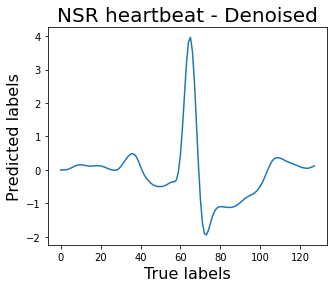

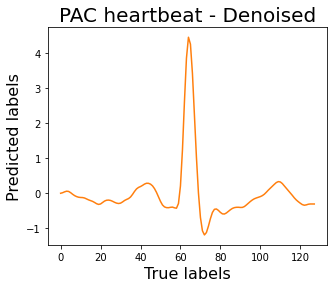

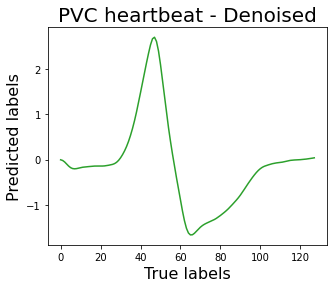

In [273]:
fig = plt.figure(figsize=(5,4))
t = np.arange(len(NSR_signal_lead1))
plt.plot(t, NSR_signal_lead1, color="C0")
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('NSR heartbeat - Denoised', fontsize=20)
plt.show()


fig = plt.figure(figsize=(5,4))
t = np.arange(len(PAC_signal_lead1))
plt.plot(t, PAC_signal_lead1, color="C1")
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('PAC heartbeat - Denoised', fontsize=20)
plt.show()

fig = plt.figure(figsize=(5,4))
t = np.arange(len(PVC_signal_lead1))
plt.plot(t, PVC_signal_lead1, color="C2")
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('PVC heartbeat - Denoised', fontsize=20)
plt.show()




## 5. Organize data for model training

### 5.1. **One-Hot-Encoding** of labels 

In [30]:
from sklearn.preprocessing import OneHotEncoder

# Transform labels vector into np.array
hbs_labels = np.asarray(hbs_labels)
hbs_labels = np.expand_dims(hbs_labels, 1)

onehot_encoder = OneHotEncoder(sparse=False)
hbs_labels = onehot_encoder.fit_transform(hbs_labels)

### 5.2. Split in **Train**, **Validation** & **Test**

Split Training and Test sets

In [31]:
from sklearn.model_selection import train_test_split

heartbeats_lead1_train, heartbeats_lead1_test, heartbeats_lead2_train, heartbeats_lead2_test, labels_train, labels_test = train_test_split(
    heartbeats_lead1,
    heartbeats_lead2,                                                                                                                                      
    hbs_labels,
    test_size=0.15,
    random_state=SEED,
    shuffle=True,
    stratify=hbs_labels
)

In [32]:
heartbeats_lead1_train, heartbeats_lead1_valid, heartbeats_lead2_train, heartbeats_lead2_valid, labels_train, labels_valid = train_test_split(
heartbeats_lead1_train,
heartbeats_lead2_train,
labels_train,
test_size=0.25,
random_state=SEED,
shuffle=True,
stratify=labels_train
)

In [33]:
# Compute labels frequency in training, valid and test sets
values, counts = np.unique(onehot_encoder.inverse_transform(labels_train), return_counts=True)
print(dict(zip(values, counts)))

values, counts = np.unique(onehot_encoder.inverse_transform(labels_valid), return_counts=True)
print(dict(zip(values, counts)))

values, counts = np.unique(onehot_encoder.inverse_transform(labels_test), return_counts=True)
print(dict(zip(values, counts)))

{0: 118137, 1: 4831, 2: 4037}
{0: 39380, 1: 1610, 2: 1346}
{0: 27797, 1: 1137, 2: 950}


### 5.3. Extract **signal**, **RR_features** and **labels** from the 'HeartBeat' objects

N.B. The 2 leads should be recombined to get an array of shape (128,2)

In [34]:
def extract_from_HeartBeats(hbs_lead1, hbs_lead2):
  pbar = ProgressBar()
  # Initialize data structures
  hbs_signals = empty_list(len(hbs_lead1))
  hbs_RRfeatures = pd.DataFrame(index=range(len(hbs_lead1)),
      columns=["pre_RR","post_RR","local_RR","global_RR"])
  hbs_labels = np.empty((len(hbs_lead1),1))
  hbs_aug = np.empty((len(hbs_lead1)))
  # Iterate across heartbeats and extract
  for i in pbar(range(len(hbs_lead1))):
    new_signal = np.c_[hbs_lead1[i].signal,
                       hbs_lead2[i].signal]
    hbs_signals[i] = new_signal

    new_RRfeat = [hbs_lead1[i].pre_RR, hbs_lead1[i].post_RR,
                  hbs_lead1[i].local_RR, hbs_lead1[i].global_RR]
    hbs_RRfeatures.loc[i,:] = new_RRfeat

    hbs_labels[i] = hbs_lead1[i].label
    hbs_aug[i] = hbs_lead1[i].aug
  
  return hbs_signals, hbs_RRfeatures, hbs_labels, hbs_aug


In [ ]:
# TRAIN (original)
signals_train, RRfeatures_train, labels_train, _ = extract_from_HeartBeats(heartbeats_lead1_train, 
                                                                           heartbeats_lead2_train)

# VALIDATION (original)
signals_valid, RRfeatures_valid, labels_valid, _ = extract_from_HeartBeats(heartbeats_lead1_valid, 
                                                                           heartbeats_lead2_valid)

# TEST (original)
signals_test, RRfeatures_test, labels_test, _ = extract_from_HeartBeats(heartbeats_lead1_test, 
                                                                        heartbeats_lead2_test)

Transform lists of np.ndarray's into np.ndarray with an additional axis

In [86]:
signals_train = np.asarray(signals_train)
RRfeatures_train = np.asarray(RRfeatures_train)

signals_valid = np.asarray(signals_valid)
RRfeatures_valid = np.asarray(RRfeatures_valid)

signals_test = np.asarray(signals_test)
RRfeatures_test = np.asarray(RRfeatures_test)

## 6. Data Augmentation
We use a GAN to repoduce fake samples of the least represented classes, so that eventually we have a dataset with **balanced** classes without wasting data.

### 6.1. Data Augmentation following *Acharya et al.*
The samples of synthetic data are generated after preprocessing by **varying the standard deviation and mean of Z-score** calculated from the original normalized ECG signals.

Consider the signals before standardization.
For each signal check its label:
- If NSR -> standardize & update;
- If, instead, it is PAC or PVC:
> - Generate random values to change the mean and std used for standardization
> - Perform standardization with these new values
> - Compute a cropped version of the signal




In [79]:
# CROPPING AND RESAMPLING -> SHIFTING + DILATATION
# Randomly crop the first or last part of the signal.
# Resample at the desired length
def crop_signal(signal):
  init_len = len(signal)

  # Crop left & right
  crop_left = int(np.random.uniform(1,16))
  crop_right = int(np.random.uniform(1,16))
  crop_signal = signal[crop_left:-crop_right]
  # Resize
  crop_signal = scipy.signal.resample(crop_signal, init_len)

  return crop_signal


def Zscore_Data_Augmentation(signal, label, class_ratios):
  aug_signal = None
  # Number of augmented samples to create 
  n_PAC_aug = round(class_ratios[0]) 
  n_PVC_aug = round(class_ratios[1])

  # Compute mean and std for the current signal
  curr_mean = np.mean(signal)
  curr_std = np.std(signal)
  
  # Check labels
  if label == 0: # NSR
    # Perform standardization
    aug_signal = Zscore_Standardization(signal,
                                        curr_mean, curr_std)
  
    aug_signal = np.expand_dims(aug_signal, 0)
  
  else: # PAC or PVC
    # Generate HALF of the synthetic samples by changing mean and std values
    # in Zscore standardization, while the other HALF is generated by randomly 
    # cropping each augmented signal
    if label == 1:
      aug_signal = empty_list(round((n_PAC_aug-0.01)/2)*2) # to get one less sample when number is odd
    elif label == 2:
      aug_signal = empty_list(round((n_PVC_aug-0.01)/2)*2)
    for i in range(0,len(aug_signal),2):
      # Modify values up to 1/3 of their original value
      rnd1 = np.random.uniform(-curr_mean/3, curr_mean/3)
      rnd2 = np.random.uniform(-curr_std/3, curr_std/3)
      # Standardize with the new values
      zaug_signal = Zscore_Standardization(signal,
                                           curr_mean + rnd1, 
                                           curr_std + rnd2)
      cropaug_signal = crop_signal(zaug_signal)
      # Store new values
      aug_signal[i] = zaug_signal
      aug_signal[i+1] = cropaug_signal

    aug_signal = np.asarray(aug_signal)

  return aug_signal

In [80]:
def Dataset_Augmentation(signals, labels, features, NSR_len):

  # Compute classes ratios
  values, counts = np.unique(labels, return_counts=True)
  classes_ratios = [round(counts[0]/counts[1]), round(counts[0]/counts[2])] 

  # Create empty data structures
  # signals_aug = np.empty((NSR_len*3,128,2))
  # labels_aug = np.empty((NSR_len*3,1))
  # features_aug = np.empty((NSR_len*3,4))
  # original_idxs = np.empty((NSR_len*3,)) # to keep track of the original signal
  signals_aug = []
  labels_aug = []
  features_aug = []
  original_idxs = [] # to keep track of the original signal

  pbar = ProgressBar()
  for i,sign in pbar(enumerate(signals)):
    # Get augmented signals for each lead
    # LEAD 1:
    curr_signal = sign[:,0]
    curr_label = labels[i]
    new_signals_lead1 = Zscore_Data_Augmentation(curr_signal, curr_label, classes_ratios)

    # LEAD 2:
    curr_signal = sign[:,1]
    new_signals_lead2 = Zscore_Data_Augmentation(curr_signal, curr_label, classes_ratios)

    # Store the augmented signals in new HeartBeat objects
    for j in range(new_signals_lead1.shape[0]):
      # Recombine the signals
      new_signal = np.column_stack((new_signals_lead1[j], new_signals_lead2[j]))
      signals_aug.append(new_signal)
      # Store the corresp label
      labels_aug.append(labels[i])
      # Store the corresp RR features
      features_aug.append(features[i,:])
      # Associate index of original signal
      original_idxs.append(i)

  signals_aug = np.asarray(signals_aug)
  labels_aug = np.asarray(labels_aug)
  features_aug = np.array(features_aug, dtype="float64")
  original_idxs = np.asarray(original_idxs)

  return signals_aug, labels_aug, features_aug, original_idxs
  

In [37]:
# Compute labels frequency in AUGMENTED training, valid and test sets
values, counts = np.unique(labels_train, return_counts=True)
print(dict(zip(values, counts)))
ratios_train = [round(counts[0]/counts[1]), round(counts[0]/counts[2])] 

values, counts = np.unique(labels_valid, return_counts=True)
print(dict(zip(values, counts)))
ratios_valid = [round(counts[0]/counts[1]), round(counts[0]/counts[2])] 

values, counts = np.unique(labels_test, return_counts=True)
print(dict(zip(values, counts)))
ratios_test = [round(counts[0]/counts[1]), round(counts[0]/counts[2])] 

{0.0: 118137, 1.0: 4831, 2.0: 4037}
{0.0: 39380, 1.0: 1610, 2.0: 1346}
{0.0: 27797, 1.0: 1137, 2.0: 950}


### 6.2. Data Augmentation only considering a subsample of NSR signals
Otherwise the computational cost both in terms of memory requirements and time is too high.

We randomly select n_NSR signals from the NSR ones. Then we perform Data Augmentation to match that number of samples for the signals of the other classes.

In [ ]:
# # Training set reduction
# values, counts = np.unique(labels_train, return_counts=True)
# n_NSR_train = 100000
# signals_train_reduced = []
# labels_train_reduced = []
# RRfeatures_train_reduced = []
# NSR_count = 0
# # Shuffle the dataset and labels
# np.random.seed(SEED)
# np.random.shuffle(signals_train)
# np.random.seed(SEED)
# np.random.shuffle(labels_train)
# np.random.seed(SEED)
# np.random.shuffle(RRfeatures_train)
# for i,signal in enumerate(signals_train):
#   if labels_train[i] == 0 and NSR_count<=n_NSR_train:
#     signals_train_reduced.append(signal)
#     labels_train_reduced.append(labels_train[i])
#     RRfeatures_train_reduced.append(RRfeatures_train[i])
#     NSR_count = NSR_count+1
#   elif labels_train[i] == 1 or labels_train[i] == 2:
#     signals_train_reduced.append(signal)
#     labels_train_reduced.append(labels_train[i])
#     RRfeatures_train_reduced.append(RRfeatures_train[i])

# signals_train_reduced = np.array(signals_train_reduced)
# labels_train_reduced = np.array(labels_train_reduced)
# RRfeatures_train_reduced = np.array(RRfeatures_train_reduced)
# print(signals_train_reduced.shape)
# print(labels_train_reduced.shape)
# print(RRfeatures_train_reduced.shape)
# print(n_NSR_train+counts[1]+counts[2])

In [ ]:
# # Validation set reduction
# values, counts = np.unique(labels_valid, return_counts=True)
# n_NSR_valid = 25000
# signals_valid_reduced = []
# labels_valid_reduced = []
# RRfeatures_valid_reduced = []
# NSR_count = 0
# # Shuffle the dataset and labels
# np.random.seed(SEED)
# np.random.shuffle(signals_valid)
# np.random.seed(SEED)
# np.random.shuffle(labels_valid)
# np.random.seed(SEED)
# np.random.shuffle(RRfeatures_valid)
# for i,signal in enumerate(signals_valid):
#   if labels_valid[i] == 0 and NSR_count<=n_NSR_valid:
#     signals_valid_reduced.append(signal)
#     labels_valid_reduced.append(labels_valid[i])
#     RRfeatures_valid_reduced.append(RRfeatures_valid[i])
#     NSR_count = NSR_count+1
#   elif labels_valid[i] == 1 or labels_valid[i] == 2:
#     signals_valid_reduced.append(signal)
#     labels_valid_reduced.append(labels_valid[i])
#     RRfeatures_valid_reduced.append(RRfeatures_valid[i])

# signals_valid_reduced = np.array(signals_valid_reduced)
# labels_valid_reduced = np.array(labels_valid_reduced)
# RRfeatures_valid_reduced = np.array(RRfeatures_valid_reduced)
# print(signals_valid_reduced.shape)
# print(labels_valid_reduced.shape)
# print(RRfeatures_valid_reduced.shape)
# print(n_NSR_valid+counts[1]+counts[2])

In [ ]:
# # Training set data augmentation
# signals_train_aug, labels_train_aug, RRfeatures_train_aug, original_idxs_train = Dataset_Augmentation(signals_train_reduced, 
#                                                                                                       labels_train_reduced, 
#                                                                                                       RRfeatures_train_reduced,
#                                                                                                       NSR_len=n_NSR_train)

In [ ]:
# # Training set data augmentation
# signals_train_aug, labels_train_aug, RRfeatures_train_aug, original_idxs_train = Dataset_Augmentation(signals_train, 
#                                                                                                       labels_train, 
#                                                                                                       RRfeatures_train,
#                                                                                                       NSR_len=len(signals_train))

In [ ]:
# values, counts = np.unique(labels_train_aug, return_counts=True)
# print(counts)

[118137 115944 113036]


In [ ]:
# # Validation set data augmentation
# signals_valid_aug, labels_valid_aug, RRfeatures_valid_aug, original_idxs_valid = Dataset_Augmentation(signals_valid_reduced, 
#                                                                                                       labels_valid_reduced, 
#                                                                                                       RRfeatures_valid_reduced,
#                                                                                                       NSR_len=n_NSR_valid)

In [ ]:
# # Validation set data augmentation
# signals_valid_aug, labels_valid_aug, RRfeatures_valid_aug, original_idxs_valid = Dataset_Augmentation(signals_valid, 
#                                                                                                       labels_valid, 
#                                                                                                       RRfeatures_valid,
#                                                                                                       NSR_len=signals_valid)

In [ ]:
# print(signals_valid_aug.shape)
# print(labels_valid_aug.shape)
# print(RRfeatures_valid_aug.shape)

In [ ]:
# values, counts = np.unique(labels_valid_aug, return_counts=True)
# print(counts)

[39380 38640 37688]


Save augmented data on disk

In [ ]:
# # Train
# train_dir2 = "/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/AugmentedData/Train"
# np.save(file=os.path.join(train_dir2, "Signals_Train_Aug"), arr=signals_train_aug)
# np.save(file=os.path.join(train_dir2, "Features_Train_Aug"), arr=RRfeatures_train_aug)
# np.save(file=os.path.join(train_dir2, "Labels_Train_Aug"), arr=labels_train_aug)

# # Valid
# valid_dir2 = "/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/AugmentedData/Valid"
# np.save(file=os.path.join(valid_dir2, "Signals_Valid_Aug"), arr=signals_valid_aug)
# np.save(file=os.path.join(valid_dir2, "Feature_Valid_Aug"), arr=RRfeatures_valid_aug)
# np.save(file=os.path.join(valid_dir2, "Labels_Valid_Aug"), arr=labels_valid_aug)

### 6.3. Load Augmented Data for training
To load one batch at the time the Augmented data saved in memory

In [ ]:
# Data generators from mmap arrays
def generate_label_shuffle(labels):
    while True:
        for i in labels:
          lab_generated = i
          yield lab_generated

def generate_signal_shuffle(signals):
    while True:
        for i in signals:
          signal_generated = i
          yield signal_generated

def generate_feature_shuffle(features):
    while True:
        for i in features:
          features_generated = i          
          yield  features_generated 

In [ ]:
# Batch generator for training data 
def batch_data_generator(batch_size, x_gen, f_gen,  y_gen):
  batch_features = np.zeros((batch_size,4))
  batch_signals = np.zeros((batch_size,128,2)) 
  batch_labels = np.zeros((batch_size,1))    
  while True:
    for i in range(batch_size):
        batch_features[i] = next(f_gen)
        batch_signals[i] = next(x_gen)
        batch_labels[i] = next(y_gen)
     
    yield {'ecg_signal': np.array(batch_signals),
           'wide_features': np.array(batch_features, dtype="float64")},{'softmax_classifier': np.array(batch_labels)}

Load **Training data** in *read-only* format

In [39]:
train_dir2 = "/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/AugmentedData/Train"
signals_train_aug = np.load(file=os.path.join(train_dir2,"Signals_Train_Aug.npy"), mmap_mode="r")
labels_train_aug = np.load(file=os.path.join(train_dir2,"Labels_Train_Aug.npy"), mmap_mode="r")
features_train_aug = np.load(file=os.path.join(train_dir2,"Features_Train_Aug.npy"), mmap_mode="r")

**One-Hot-Encoding** of the labels

In [40]:
labels_train_aug = tf.keras.utils.to_categorical(labels_train_aug, num_classes=3)
print(labels_train_aug.shape)

(347117, 3)


Load **Validation data** in *read-only* format

In [41]:
valid_dir2 = "/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/AugmentedData/Valid"
signals_valid_aug = np.load(file=os.path.join(valid_dir2,"Signals_Valid_Aug.npy"), mmap_mode="r")
labels_valid_aug = np.load(file=os.path.join(valid_dir2,"Labels_Valid_Aug.npy"), mmap_mode="r")
features_valid_aug = np.load(file=os.path.join(valid_dir2,"Feature_Valid_Aug.npy"), mmap_mode="r")

**One-Hot-Encoding** of the labels

In [42]:
labels_valid_aug = tf.keras.utils.to_categorical(labels_valid_aug, num_classes=3)
print(labels_valid_aug.shape)

(115708, 3)


## 7. Model Definition and Training

In [38]:
input_shape = (128,2)
num_classes = 3
batchsize = 64

### 7.1. **ResNet** + **Wide features** trained on the **Augmented Training set**

In [43]:
# ResNet model definition 
def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout)
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def resnet(N=8, ch=2, win_len=128, classes=3): 
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64, kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N-2)/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet) 

    # Sigmoid activation function on the last layer
    ResNet = Dense(classes, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input],outputs=ResNet)
    return model


In [44]:
# model integrating deep + wide 
def resnet_deep_wide(N, ch, win_len, num_wide_features, classes): 
    # A. Wide features
    wide_input = Input(shape=(num_wide_features,), name ='wide_features')
    wide_branch = Dense(4, activation='relu')(wide_input)
    wide_branch = Dense(2, activation='relu')(wide_branch)

    # B. ECG window input of shape (batch_size,  WINDOW_LEN, CHANNELS)
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks
    
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N-2)/2)
    for i in range(M): 
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    shared_path = concatenate([ResNet, wide_branch], name='concat_layer')
    shared_path = Dense(classes, activation='softmax', name='softmax_classifier')(shared_path)
   
    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input,  wide_input],outputs=shared_path)

    return model

In [45]:
resNet_deep_wide_model = resnet_deep_wide(N=8, ch=2, win_len=128, num_wide_features= 4, classes=3)

In [ ]:
resNet_deep_wide_model.summary()

In [46]:
resNet_deep_wide_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.01),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall']
)

In [47]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor="val_loss",
                           patience=20,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=8, min_lr=0.0001, verbose=1)

clbks = [early_stop, reduce_lr]

In [48]:
history = resNet_deep_wide_model.fit(
    x=[signals_train_aug,features_train_aug],
    y=labels_train_aug,
    validation_data=([signals_valid_aug, features_valid_aug], 
                     labels_valid_aug),
    steps_per_epoch=(len(signals_train_aug)/batchsize),
    batch_size = batchsize,
    epochs = 20,
    callbacks = clbks
).history

Epoch 1/40
5423/5423 [==============================] - 257s 44ms/step - loss: 0.2453 - accuracy: 0.9163 - precision: 0.9220 - recall: 0.9106 - val_loss: 0.3817 - val_accuracy: 0.8806 - val_precision: 0.8839 - val_recall: 0.8776 - lr: 0.0100
Epoch 2/40
5423/5423 [==============================] - 234s 43ms/step - loss: 0.1072 - accuracy: 0.9623 - precision: 0.9634 - recall: 0.9614 - val_loss: 0.1132 - val_accuracy: 0.9646 - val_precision: 0.9650 - val_recall: 0.9641 - lr: 0.0100
Epoch 3/40
5423/5423 [==============================] - 234s 43ms/step - loss: 0.0785 - accuracy: 0.9720 - precision: 0.9725 - recall: 0.9715 - val_loss: 0.1067 - val_accuracy: 0.9671 - val_precision: 0.9676 - val_recall: 0.9666 - lr: 0.0100
Epoch 4/40
5423/5423 [==============================] - 234s 43ms/step - loss: 0.0571 - accuracy: 0.9793 - precision: 0.9796 - recall: 0.9790 - val_loss: 0.1002 - val_accuracy: 0.9719 - val_precision: 0.9722 - val_recall: 0.9716 - lr: 0.0100
Epoch 5/40
5423/5423 [==========

In [49]:
# # Save trained model
# model_directory = '/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/Models/'
# filename = 'augmented_wide_resNet_trained'
# filename_chosen = os.path.join(model_directory, filename)
# resNet_deep_wide_model.save(filename_chosen + '.h5')

### 7.2. Load Pre-Trained Models

Wide ResNet model

In [44]:
resNet_deep_wide_model = load_model("/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/Models/augmented_wide_resNet_trained.h5")

## 8. Model Evaluation

### 8.1. Learning Performances on Training & Validation

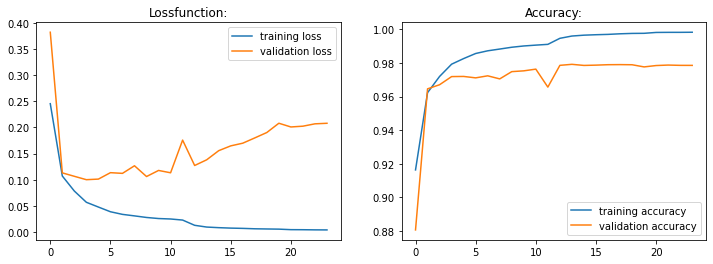

In [67]:
#plot performances
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Lossfunction:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy:')
plt.legend()

### 8.2. Prediction on the **Original Test set**

In [ ]:
# Training set data augmentation
signals_test_aug, labels_test_aug, RRfeatures_test_aug, original_idxs_test = Dataset_Augmentation(
    signals_test, 
    labels_test, 
    RRfeatures_test,
    NSR_len=len(signals_test)
)

Predict labels for the test set

In [197]:
pred = resNet_deep_wide_model.predict([signals_test_aug, RRfeatures_test_aug.astype("float64")])
predicted_class = np.argmax(pred, axis=-1)

y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

In [ ]:
# One hot encoding of test labels
labels_test_onehot = tf.keras.utils.to_categorical(labels_test_aug, num_classes=3)

In [ ]:
cm = sklearn.metrics.confusion_matrix(np.argmax(labels_test_onehot,axis=1),np.argmax(pred,axis=1))

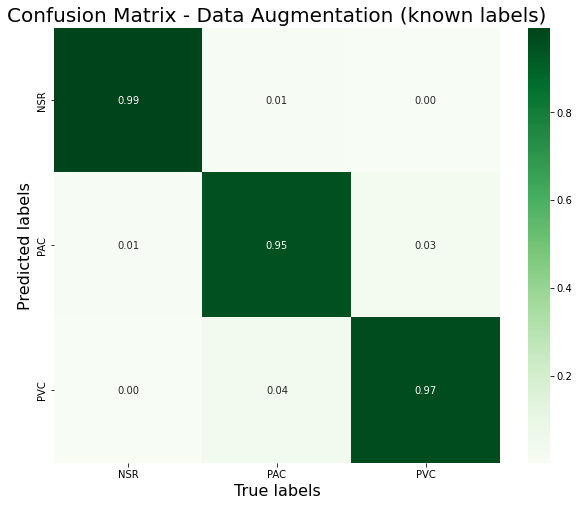

In [204]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(classes_names), yticklabels=list(classes_names),
            cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('Confusion Matrix - Data Augmentation (known labels)', fontsize=20)
plt.show()

Compute standard metrics

In [203]:
metrics = sklearn.metrics.classification_report(y_true=np.argmax(labels_test_onehot,axis=1),
                                                y_pred=np.argmax(pred,axis=1),
                                                output_dict=True)
metrics

{'0': {'precision': 0.9891308246941923,
  'recall': 0.9919775515343382,
  'f1-score': 0.9905521428314833,
  'support': 27797},
 '1': {'precision': 0.9629889817348222,
  'recall': 0.9544488419818236,
  'f1-score': 0.9586998932528435,
  'support': 27288},
 '2': {'precision': 0.9596442717285704,
  'recall': 0.9654887218045113,
  'f1-score': 0.962557625276414,
  'support': 26600},
 'accuracy': 0.9708147150639652,
 'macro avg': {'precision': 0.9705880260525283,
  'recall': 0.9706383717735577,
  'f1-score': 0.9706032204535803,
  'support': 81685},
 'weighted avg': {'precision': 0.9707957457989136,
  'recall': 0.9708147150639652,
  'f1-score': 0.9707952920820585,
  'support': 81685}}

Average prediction returning to the original samples

In [205]:
def Test_Time_Majority_Voting(pred_labels, original_idxs):
  i = 0
  n_test = len(original_idxs)
  pred_classes = [] # store majority class for each sample

  # Iterate over the samples:
  pbar = ProgressBar()
  for idx in (np.unique(original_idxs)):
    curr_idx = idx
    # print("Set curr_idx: " + str(curr_idx))
    new_idx = curr_idx
    # print("Set new_idx: " + str(new_idx))
    labels_temp = []
    # Check when index changes
    while new_idx == curr_idx:
      # Store new pred_labels
      labels_temp.append(pred_labels[i])
      # print("Labels temp: ", labels_temp)
      i = i + 1
      # print("Update i: " + str(i))
      if i < n_test:
        new_idx = original_idxs[i]
        # print("Update new_idx: " + str(new_idx))
      else:
        break
    
    # Majority voting over the stored labels
    val, cnt = np.unique(labels_temp, return_counts=True)
    dizio = dict(zip(val,cnt))
    majority_class = max(dizio, key=dizio.get)
    # print("MAJORITY CLASS: " + str(majority_class))
    pred_classes.append(majority_class)
  
  return pred_classes

In [206]:
pred_classes = Test_Time_Majority_Voting(predicted_class, original_idxs_test)

In [ ]:
cm = sklearn.metrics.confusion_matrix(labels_test,pred_classes)

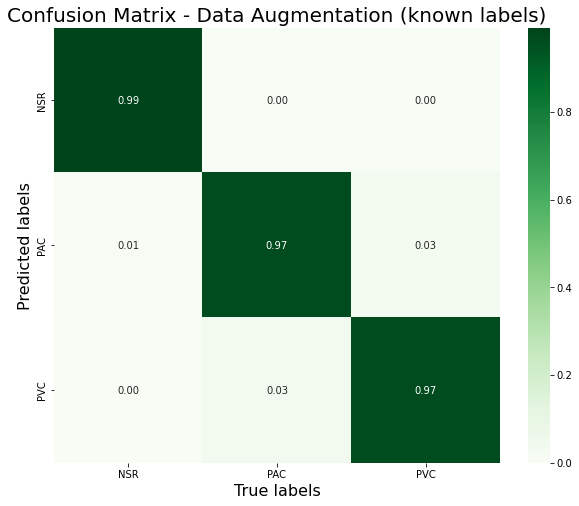

In [208]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(classes_names), yticklabels=list(classes_names),
            cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('Confusion Matrix - Data Augmentation (known labels)', fontsize=20)
plt.show()

Compute standard metrics

In [174]:
metrics = sklearn.metrics.classification_report(y_true=np.argmax(labels_test_onehot,axis=1),
                                                y_pred=np.argmax(pred,axis=1),
                                                output_dict=True)
metrics

{'0': {'precision': 0.9891308246941923,
  'recall': 0.9919775515343382,
  'f1-score': 0.9905521428314833,
  'support': 27797},
 '1': {'precision': 0.9629889817348222,
  'recall': 0.9544488419818236,
  'f1-score': 0.9586998932528435,
  'support': 27288},
 '2': {'precision': 0.9596442717285704,
  'recall': 0.9654887218045113,
  'f1-score': 0.962557625276414,
  'support': 26600},
 'accuracy': 0.9708147150639652,
 'macro avg': {'precision': 0.9705880260525283,
  'recall': 0.9706383717735577,
  'f1-score': 0.9706032204535803,
  'support': 81685},
 'weighted avg': {'precision': 0.9707957457989136,
  'recall': 0.9708147150639652,
  'f1-score': 0.9707952920820585,
  'support': 81685}}

### 8.3. Test Time Data Augmentation 

In [177]:
# CROPPING AND RESAMPLING -> SHIFTING + DILATATION
# Randomly crop the first or last part of the signal.
# Resample at the desired length
def crop_signal(signal):
  init_len = len(signal)

  # Crop left & right
  crop_left = int(np.random.uniform(1,16))
  crop_right = int(np.random.uniform(1,16))
  crop_signal = signal[crop_left:-crop_right]
  # Resize
  crop_signal = scipy.signal.resample(crop_signal, init_len)

  return crop_signal


def Test_Time_Data_Augmentation(signal, N_aug):
  
  # Compute mean and std for the current signal
  curr_mean = np.mean(signal)
  curr_std = np.std(signal)
  
  # Data structure to store augmented signals
  aug_signal = empty_list(N_aug)

  # Generate the augmented signals
  for i in range(0,len(aug_signal),2):
    # Modify values up to 1/3 of their original value
    rnd1 = np.random.uniform(-curr_mean/3, curr_mean/3)
    rnd2 = np.random.uniform(-curr_std/3, curr_std/3)
    # Standardize with the new values
    zaug_signal = Zscore_Standardization(signal,
                                         curr_mean + rnd1, 
                                         curr_std + rnd2)
    cropaug_signal = crop_signal(zaug_signal)
    # Store new values
    aug_signal[i] = zaug_signal
    aug_signal[i+1] = cropaug_signal

  aug_signal = np.asarray(aug_signal)

  return aug_signal

In [209]:
def TTDA(signals, features, N_aug=10):
  """
  N.B. At Test Time we suppose we don't know the true labels of the data.
  Therefore, the aim of Data Augmentation is to get more robust 
  predictions averaging the predictions on augmented versions of the same 
  sample, rather than to solve the CLASS IMBALANCE problem.
  Therefore, in this case, for each sample, 
  - we generate N augmented samples;
  - we predict the class for each augmented samples;
  - the final predicted label for the orginal sample is given by the argmax 
    of the mean prediction score.
  """
  # Create empty data structures
  predictions = np.empty(len(signals))
  signals_aug = []
  features_aug = []

  pbar = ProgressBar()
  for i,sign in pbar(enumerate(signals)):
    # Get augmented signals for each lead
    # LEAD 1:
    curr_signal = sign[:,0]
    new_signals_lead1 = Test_Time_Data_Augmentation(curr_signal, N_aug)

    # LEAD 2:
    curr_signal = sign[:,1]
    new_signals_lead2 = Test_Time_Data_Augmentation(curr_signal, N_aug)

    # Store the augmented signals predictions in a temp object
    signals_temp = np.zeros((N_aug,128,2))
    features_temp = np.zeros((N_aug,4))
    for j in range(new_signals_lead1.shape[0]):
      # Recombine the signals
      new_signal = np.column_stack((new_signals_lead1[j], new_signals_lead2[j]))
      signals_temp[j] = new_signal
      features_temp[j] = features[i,:]
    
    # Add to main data structures
    signals_aug.append(signals_temp)
    features_aug.append(features_temp)
  
  signals_aug = np.asarray(signals_aug).reshape((len(signals)*N_aug,128,2))
  features_aug = np.asarray(features_aug).reshape((len(signals)*N_aug,4))
  print("\n Data augmentation completed! \n")

  return signals_aug, features_aug

In [ ]:
signals_aug, features_aug = TTDA(signals=signals_test, features=RRfeatures_test, N_aug=10)

In [211]:
pred = resNet_deep_wide_model.predict([signals_aug, features_aug.astype("float64")])
predicted_class = np.argmax(pred, axis=-1)

y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

Average prediction returning to the original samples

In [ ]:
original_idxs = np.repeat(np.arange(len(signals_test)), 10, axis=0)
pred_classes = Test_Time_Majority_Voting(predicted_class, original_idxs)

In [ ]:
cm = sklearn.metrics.confusion_matrix(labels_test,pred_classes)

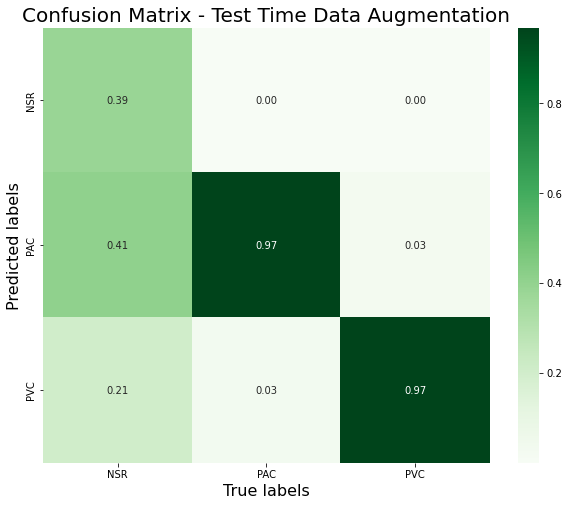

In [216]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(classes_names), yticklabels=list(classes_names),
            cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('Confusion Matrix - Test Time Data Augmentation', fontsize=20)
plt.show()

In [217]:
metrics = sklearn.metrics.classification_report(labels_test,pred_classes,
                                                output_dict=True)
metrics

{'0.0': {'precision': 0.9997198094704399,
  'recall': 0.38507752635176457,
  'f1-score': 0.5559941824226053,
  'support': 27797},
 '1.0': {'precision': 0.08794814340588988,
  'recall': 0.9665787159190853,
  'f1-score': 0.16122643585417737,
  'support': 1137},
 '2.0': {'precision': 0.1375542583445592,
  'recall': 0.9673684210526315,
  'f1-score': 0.240859651421832,
  'support': 950},
 'accuracy': 0.42571275598982733,
 'macro avg': {'precision': 0.4084074037402963,
  'recall': 0.7730082211078271,
  'f1-score': 0.31936008989953824,
  'support': 29884},
 'weighted avg': {'precision': 0.9376216412906454,
  'recall': 0.42571275598982733,
  'f1-score': 0.5309564119668753,
  'support': 29884}}